In [3]:
from Bio import PDB
from Bio.PDB import Superimposer
from Bio.PDB import DSSP
from Bio.PDB.DSSP import dssp_dict_from_pdb_file
import os
import csv
import pandas as pd
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
import math

C:\Users\lilli\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [4]:
def get_secondary_structure(structure, fp):
    model = structure[0]  # Assuming single model
    dssp = DSSP(model, fp)  # You need the actual file path for DSSP
    return {residue: dssp[key][2] for key, residue in dssp.keys()}

In [5]:
def calculate_rmsd(fixed_atoms, moving_atoms, structure):
    super_imposer = Superimposer()
    super_imposer.set_atoms(fixed_atoms, moving_atoms)
    super_imposer.apply(structure.get_atoms())
    return super_imposer.rms

In [6]:
p = PDB.PDBParser(QUIET=True)
pdb_directory = "output_lilli/"
ref_structure = p.get_structure('fixed', 'SARS-CoV-ACE2_residues.pdb')

In [7]:
crystal_structure = p.get_structure('crystal', '6m0j.pdb')
crys_model = crystal_structure[0]

for chain in crys_model:
    if chain.id == 'E':
        fixed_crys_atoms = [residue['CA'] for residue in chain.get_residues() if 'CA' in residue]
        moving_ref_atoms = [residue['CA'] for residue in ref_structure.get_residues() if 'CA' in residue]
        print(len(fixed_crys_atoms), len(moving_ref_atoms))
        moving_ref_atoms.pop()
        assert len(fixed_crys_atoms) == len(moving_ref_atoms)
        rmsd = calculate_rmsd(fixed_crys_atoms, moving_ref_atoms, chain)
        print(rmsd)


194 195
18.957933346331075


In [8]:
from tmtools.io import get_structure, get_residue_data
from tmtools import tm_align
ref_s = get_structure('SARS-CoV-ACE2_residues.pdb')
chain = next(ref_s.get_chains())
ref_coords, ref_seq = get_residue_data(chain)

In [27]:
import os
import pandas as pd
from Bio import PDB

def calculate_average_b_factor(structure):
    len_prot = [atom for residue in structure.get_residues() for atom in residue]
    bfactor = sum(atom.get_bfactor() for model in structure for chain in model for residue in chain for atom in residue)
    return bfactor / len(len_prot)

def get_amino_acids(structure):
    amino_acids = set()
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == ' ' and residue.id[2] == ' ':
                    amino_acids.add(residue.get_resname())
    return amino_acids

def create_amino_acid_changes_matrix(pdb_directory):
    parser = PDB.PDBParser(QUIET=True)
    amino_acids = set()

    for pdb_file in os.listdir(pdb_directory):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(pdb_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            amino_acids.update(get_amino_acids(structure))

    amino_acids = sorted(amino_acids)

    df_BF = pd.DataFrame(index=amino_acids, columns=amino_acids)

    for pdb_file in os.listdir(pdb_directory):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(pdb_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            old_aa = None
            for model in structure:
                for chain in model:
                    for residue in chain:
                        if residue.id[0] == ' ' and residue.id[2] == ' ':
                            new_aa = residue.get_resname()
                            if old_aa is not None and new_aa != old_aa:
                                bfactor = calculate_average_b_factor(structure)
                                df_BF.loc[old_aa, new_aa] = bfactor
                            old_aa = new_aa

    return df_BF

# Specify the directory containing your PDB files
pdb_directory = 'output_lilli/'

# Create the amino acid changes matrix
df_amino_acid_changes = create_amino_acid_changes_matrix(pdb_directory)
print(df_amino_acid_changes)



           ALA        ARG        ASN        ASP        CYS        GLN  \
ALA        NaN  43.222916  22.644127    24.8875  26.554966  39.934753   
ARG  43.222916        NaN  43.222916  34.145804  43.222916    24.8875   
ASN  22.863403  22.863403        NaN  22.863403    24.8875  39.934753   
ASP  46.255425  43.222916  22.644127        NaN  46.255425  39.934753   
CYS  26.554966  43.222916  22.863403  46.255425        NaN  26.554966   
GLN  23.936385  43.222916  39.934753  39.934753  39.934753        NaN   
GLU  45.343191  22.863403  22.644127  84.062727  45.343191  39.934753   
GLY  23.980204  43.222916    24.8875  22.863403  22.863403    24.8875   
HIS  22.863403  20.142327  20.142327  20.142327  20.142327  39.934753   
ILE  22.863403  25.094095  22.644127  46.440253  46.440253  39.934753   
LEU  57.734968  43.222916  22.863403  22.863403    24.8875  22.863403   
LYS  49.320905    24.8875  22.644127  49.320905  22.863403  39.934753   
MET  40.411322  40.411322  40.411322  40.411322  40

In [12]:
import os
import pandas as pd
from Bio import PDB
from tmtools.io import get_structure, get_residue_data
from tmtools import tm_align
import numpy as np

def get_amino_acids(structure):
    amino_acids = set()
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.id[0] == ' ' and residue.id[2] == ' ':
                    amino_acids.add(residue.get_resname())
    return amino_acids

def create_amino_acid_changes_matrix(pdb_directory):
    parser = PDB.PDBParser(QUIET=True)
    amino_acids = set()

    for pdb_file in os.listdir(pdb_directory):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(pdb_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            amino_acids.update(get_amino_acids(structure))
            
    amino_acids = sorted(amino_acids)

    df_BF = pd.DataFrame(index=amino_acids, columns=amino_acids)

    for pdb_file in os.listdir(pdb_directory):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(pdb_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            
            chain = next(structure.get_chains())
            coords, seq = get_residue_data(chain)

            old_aa = None
            for model in structure:
                for chain in model:
                    for residue in chain:
                        if residue.id[0] == ' ' and residue.id[2] == ' ':
                            new_aa = residue.get_resname()
                            if old_aa is not None and new_aa != old_aa:
                                #bfactor = calculate_average_b_factor(structure)
                                
                                res = tm_align(ref_coords, coords, ref_seq, seq)
                                tm_score = res.tm_norm_chain1
                                #len_prot = [atom for residue in structure.get_residues() for atom in residue]
                                #average_tm_score = tm_score / len(len_prot)
                                
                                #df_BF.loc[old_aa, new_aa] = average_tm_score
                                df_BF.loc[old_aa, new_aa] = tm_score
                            old_aa = new_aa

    return df_BF

# Specify the directory containing your PDB files
pdb_directory = 'output_lilli/'

# Create the amino acid changes matrix
df_amino_acid_changes = create_amino_acid_changes_matrix(pdb_directory)
print(df_amino_acid_changes)


          ALA       ARG       ASN       ASP       CYS       GLN       GLU  \
ALA       NaN  0.187454  0.255288  0.279718  0.228699  0.231611  0.142677   
ARG  0.187454       NaN  0.187454  0.284754  0.187454  0.279718  0.209238   
ASN    0.4089    0.4089       NaN    0.4089  0.279718  0.231611  0.255288   
ASP  0.196254  0.187454  0.255288       NaN  0.196254  0.231611    0.4089   
CYS  0.228699  0.187454    0.4089  0.196254       NaN  0.228699  0.142677   
GLN  0.420881  0.187454  0.231611  0.231611  0.231611       NaN  0.231611   
GLU  0.142677    0.4089  0.255288  0.150588  0.142677  0.231611       NaN   
GLY   0.28271  0.187454  0.279718    0.4089    0.4089  0.279718  0.279718   
HIS    0.4089  0.318313  0.318313  0.318313  0.318313  0.231611  0.318313   
ILE    0.4089  0.252654  0.255288  0.211072  0.211072  0.231611  0.211072   
LEU  0.231395  0.187454    0.4089    0.4089  0.279718    0.4089  0.231395   
LYS  0.171005  0.279718  0.255288  0.171005    0.4089  0.231611  0.171005   

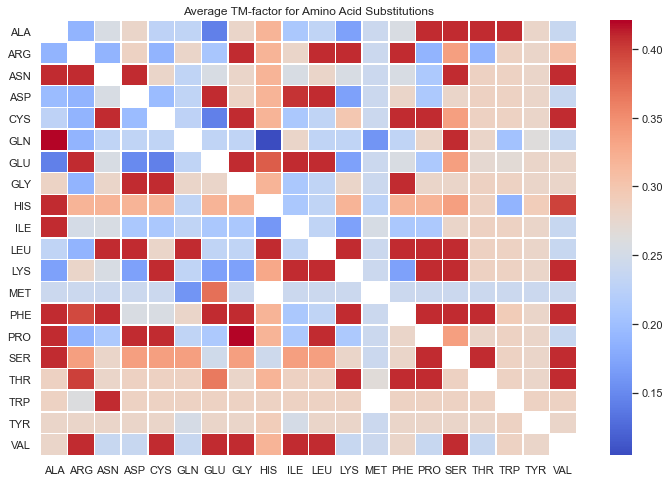

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df_amino_acid_changes is your DataFrame
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Plot heatmap without numerical annotations
sns.heatmap(df_amino_acid_changes.astype(float), annot=False, cmap="coolwarm", linewidths=.5)

plt.title('Average TM-factor for Amino Acid Substitutions')
plt.show()


In [25]:
len_prot = [atom for residue in ref_structure.get_residues() for atom in residue]
bfactor = 0
for model in ref_structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                bf = atom.get_bfactor()
                bfactor += bf
bfactor = bfactor / len(len_prot)
print(bfactor)

23.304115359688907


# NEW

In [18]:
import os
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from tmtools.io import get_residue_data
from tmtools import tm_align

def calculate_tm_scores_for_trajectory(trajectory_directory, reference_structure):
    parser = PDBParser(QUIET=True)
    tm_scores = []
    ref_structure = parser.get_structure('reference', reference_structure)
    ref_chain = next(ref_structure.get_chains())
    ref_coords, ref_seq = get_residue_data(ref_chain)

    for pdb_file in sorted(os.listdir(trajectory_directory)):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(trajectory_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            chain = next(structure.get_chains())
            coords, seq = get_residue_data(chain)
            tm_result = tm_align(ref_coords, coords, ref_seq, seq)
            tm_score = tm_result.tm_norm_chain1
            tm_scores.append(tm_score)

    return tm_scores

def plot_tm_score_trajectory(tm_scores):
    plt.plot(range(len(tm_scores)), tm_scores)
    plt.xlabel('Time Step')
    plt.ylabel('TM Score')
    plt.title('TM Score Trajectory')
    plt.show()

# Example usage
trajectory_directory = 'ESM/output_esm/trajectories_1/'
reference_structure = 'ESM/tmscore/ACE2.pdb'
tm_scores = calculate_tm_scores_for_trajectory(trajectory_directory, reference_structure)
#plot_tm_score_trajectory(tm_scores)


In [45]:
import os
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from tmtools.io import get_residue_data
from tmtools import tm_align

def calculate_tm_scores_for_trajectory(trajectory_directory, reference_structure):
    parser = PDBParser(QUIET=True)
    tm_scores = []
    file_scores = []

    ref_structure = parser.get_structure('reference', reference_structure)
    ref_chain = next(ref_structure.get_chains())
    ref_coords, ref_seq = get_residue_data(ref_chain)

    for pdb_file in sorted(os.listdir(trajectory_directory)):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(trajectory_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            chain = next(structure.get_chains())
            coords, seq = get_residue_data(chain)
            tm_result = tm_align(ref_coords, coords, ref_seq, seq)
            tm_score = tm_result.tm_norm_chain1
            tm_scores.append(tm_score)
            file_scores.append((pdb_file, tm_score))

    return file_scores

# Example usage
trajectory_directory = 'ESM/output_esm/trajectories_1/'
reference_structure = 'SARS-CoV-ACE2_residues.pdb'
tm_scores = calculate_tm_scores_for_trajectory(trajectory_directory, reference_structure)
print(tm_scores)


[('A_trajectory_1.fasta_0.pdb', 0.4444599759201637), ('A_trajectory_10.fasta_0.pdb', 0.4014036924706873), ('A_trajectory_100.fasta_0.pdb', 0.25268162191014304), ('A_trajectory_101.fasta_0.pdb', 0.24305550185051053), ('A_trajectory_102.fasta_0.pdb', 0.2455272268802556), ('A_trajectory_103.fasta_0.pdb', 0.29851035110093455), ('A_trajectory_104.fasta_0.pdb', 0.33269046779686634), ('A_trajectory_105.fasta_0.pdb', 0.2345427828012642), ('A_trajectory_106.fasta_0.pdb', 0.28650480034375375), ('A_trajectory_107.fasta_0.pdb', 0.290539261355015), ('A_trajectory_108.fasta_0.pdb', 0.25239368042107924), ('A_trajectory_109.fasta_0.pdb', 0.26623013150039), ('A_trajectory_11.fasta_0.pdb', 0.39103183113966766), ('A_trajectory_110.fasta_0.pdb', 0.237699906911067), ('A_trajectory_111.fasta_0.pdb', 0.2755172685099256), ('A_trajectory_112.fasta_0.pdb', 0.2602730519636993), ('A_trajectory_113.fasta_0.pdb', 0.24113930043694606), ('A_trajectory_114.fasta_0.pdb', 0.23307389219290264), ('A_trajectory_115.fasta_0

In [98]:
len(tm_scores)

3705

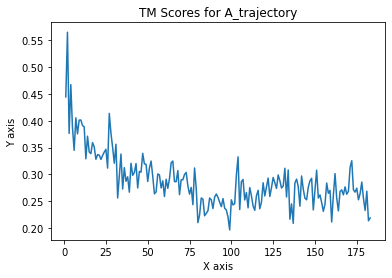

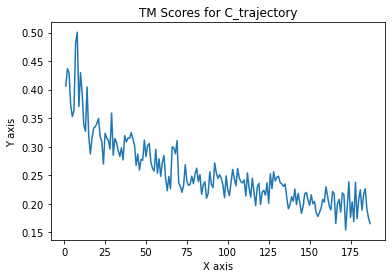

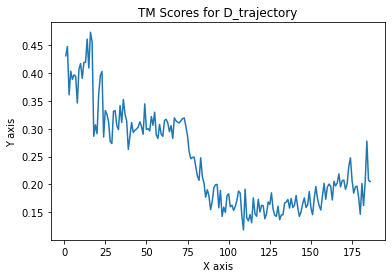

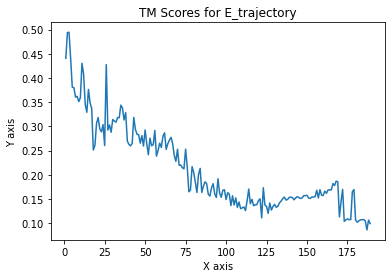

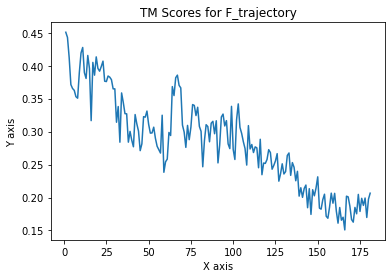

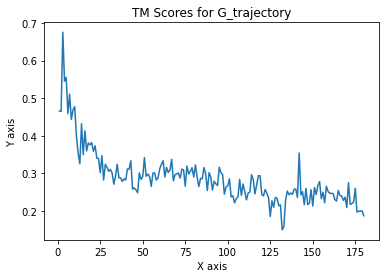

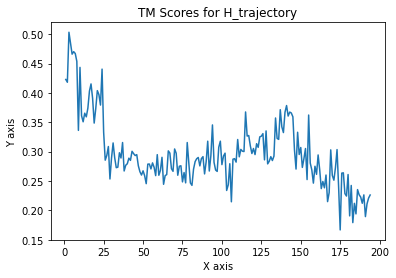

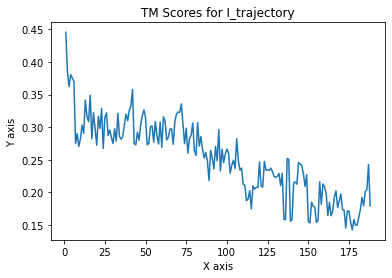

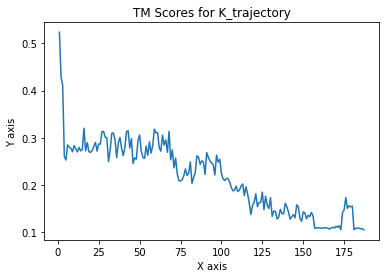

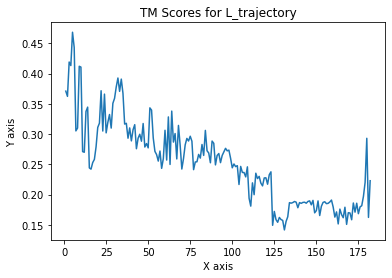

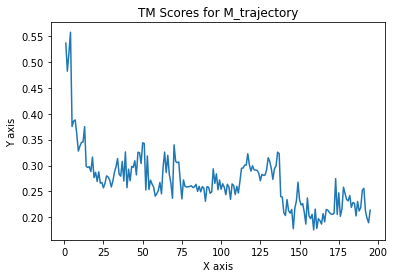

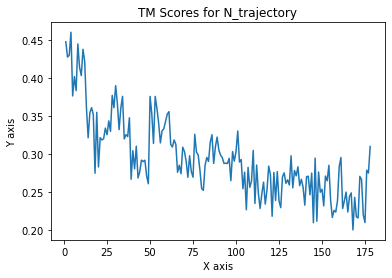

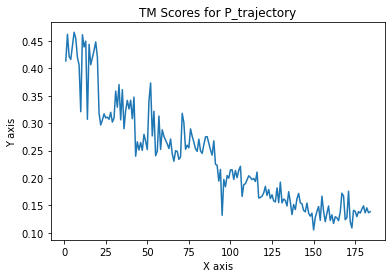

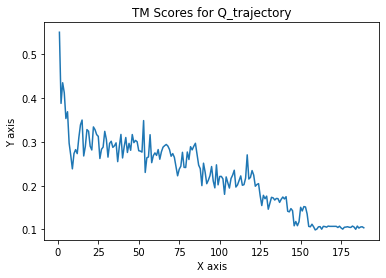

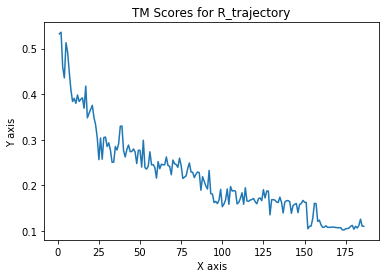

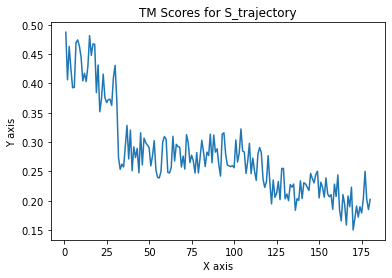

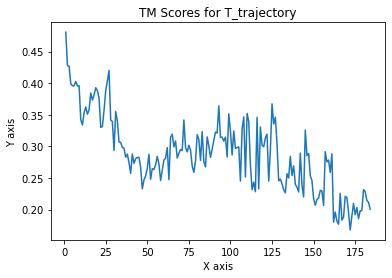

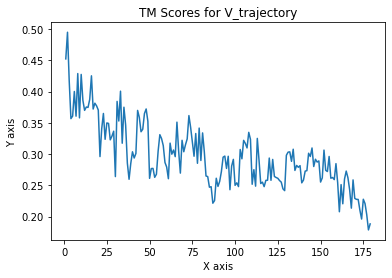

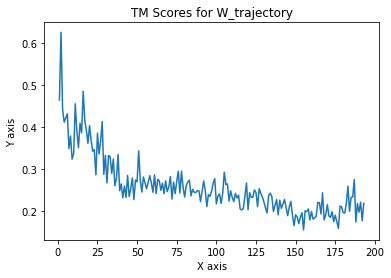

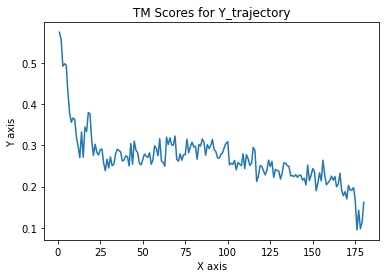

In [47]:
def sort_key(item):
    match = re.search(r'([A-Z]_trajectory)_(\d+)\.fasta_0\.pdb', item[0])
    amino_acid = match.group(1)
    trajectory_number = int(match.group(2))
    return amino_acid, trajectory_number

# Sort the list based on the custom sorting function
tm_scores.sort(key=sort_key)

# Group scores by amino acid
amino_acids = {}
for item in tm_scores:
    match = re.search(r'([A-Z]_trajectory)_(\d+)\.fasta_0\.pdb', item[0])
    amino_acid = match.group(1)
    if amino_acid not in amino_acids:
        amino_acids[amino_acid] = []
    amino_acids[amino_acid].append(item)

# Plot for each amino acid
for amino_acid, scores in amino_acids.items():
    x_values = range(1, len(scores) + 1)
    y_values = [score[1] for score in scores]
    
    plt.figure()
    plt.plot(x_values, y_values)
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.title(f'TM Scores for {amino_acid}')
    plt.show()

In [50]:
import os
import matplotlib.pyplot as plt
from Bio.PDB import PDBParser
from tmtools.io import get_residue_data
from tmtools import tm_align

def calculate_tm_scores_for_trajectory(trajectory_directory, reference_structure):
    parser = PDBParser(QUIET=True)
    tm_scores = []
    file_scores = []

    ref_structure = parser.get_structure('reference', reference_structure)
    ref_chain = next(ref_structure.get_chains())
    ref_coords, ref_seq = get_residue_data(ref_chain)

    for pdb_file in sorted(os.listdir(trajectory_directory)):
        if pdb_file.endswith(".pdb"):
            pdb_path = os.path.join(trajectory_directory, pdb_file)
            structure = parser.get_structure('PDB', pdb_path)
            chain = next(structure.get_chains())
            coords, seq = get_residue_data(chain)
            tm_result = tm_align(ref_coords, coords, ref_seq, seq)
            tm_score = tm_result.tm_norm_chain1
            tm_scores.append(tm_score)
            file_scores.append((pdb_file, tm_score))

    print('test')
        
    return file_scores

# Example usage
trajectory_directories = ['ESM/output_esm/trajectories_1/', 'ESM/output_esm/trajectories_2/', 'ESM/output_esm/trajectories_3/']
reference_structure = 'SARS-CoV-ACE2_residues.pdb'
tm_scores_lists = []

for trajectory_directory in trajectory_directories:
    tm_scores_lists.append(calculate_tm_scores_for_trajectory(trajectory_directory, reference_structure))


test
test
test


In [109]:
import os
from Bio.PDB import PDBParser
from tmtools.io import get_residue_data
from tmtools import tm_align

def calculate_tm_scores_for_trajectory(trajectory_directories, reference_structure):
    parser = PDBParser(QUIET=True)
    tm_scores = {}

    ref_structure = parser.get_structure('reference', reference_structure)
    ref_chain = next(ref_structure.get_chains())
    ref_coords, ref_seq = get_residue_data(ref_chain)

    for directory in trajectory_directories:
        trajectory_scores = []
        for pdb_file in sorted(os.listdir(directory)):
            if pdb_file.endswith(".pdb"):
                pdb_path = os.path.join(directory, pdb_file)
                structure = parser.get_structure('PDB', pdb_path)
                chain = next(structure.get_chains())
                coords, seq = get_residue_data(chain)
                tm_result = tm_align(ref_coords, coords, ref_seq, seq)
                tm_score = tm_result.tm_norm_chain1
                trajectory_scores.append(tm_score)
        tm_scores[directory] = trajectory_scores

    return tm_scores

# Example usage
trajectory_directories = ['ESM/plotting_test/trajectories_1/', 'ESM/plotting_test/trajectories_2/', 'ESM/plotting_test/trajectories_3/']
reference_structure = 'SARS-CoV-ACE2_residues.pdb'
tm_scores = calculate_tm_scores_for_trajectory(trajectory_directories, reference_structure)
print(tm_scores)


{'ESM/plotting_test/trajectories_1/': [0.4444599759201637, 0.5649142947635462, 0.37649227200415886, 0.4672884174717147, 0.3871485580837371, 0.34485374755791015, 0.405451963526002, 0.37556334585158685, 0.4063421814526716, 0.43673164697524325, 0.429546739630539, 0.37205734036863847, 0.35297921093716883, 0.3636518435084993, 0.481012820088875, 0.5005351496575617, 0.4310364336404004, 0.44761701523269537, 0.3608719171297976, 0.40349118337536244, 0.388571671562773, 0.3967032255049098, 0.3942899957223393, 0.346271056900473], 'ESM/plotting_test/trajectories_2/': [0.5243604481271879, 0.507001470801699, 0.41138316813683534, 0.47292707872198203, 0.47001615397944907, 0.4478469712682843, 0.4885353953979822, 0.4552146229877774, 0.4498841638886758, 0.45962844555945037, 0.3876240883803287, 0.3904651143294351, 0.4185652069924563, 0.3962375648949401, 0.3390619698265235, 0.26313569927750713, 0.4880577493445456, 0.4655790467567323, 0.45772158316372247, 0.46858390819877455, 0.4848349384269262, 0.36613722196

In [110]:
import os
from Bio.PDB import PDBParser
from tmtools.io import get_residue_data
from tmtools import tm_align

def calculate_tm_scores_for_trajectory(trajectory_directories, reference_structure):
    parser = PDBParser(QUIET=True)
    tm_scores = []

    ref_structure = parser.get_structure('reference', reference_structure)
    ref_chain = next(ref_structure.get_chains())
    ref_coords, ref_seq = get_residue_data(ref_chain)

    for directory in trajectory_directories:
        for pdb_file in sorted(os.listdir(directory)):
            if pdb_file.endswith(".pdb"):
                pdb_path = os.path.join(directory, pdb_file)
                structure = parser.get_structure('PDB', pdb_path)
                chain = next(structure.get_chains())
                coords, seq = get_residue_data(chain)
                tm_result = tm_align(ref_coords, coords, ref_seq, seq)
                tm_score = tm_result.tm_norm_chain1
                trajectory_scores = [pdb_file] + [tm_score] * 3
                tm_scores.append(tuple(trajectory_scores))

    return tm_scores

# Example usage
trajectory_directories = ['ESM/plotting_test/trajectories_1/', 'ESM/plotting_test/trajectories_2/', 'ESM/plotting_test/trajectories_3/']
reference_structure = 'SARS-CoV-ACE2_residues.pdb'
tm_scores = calculate_tm_scores_for_trajectory(trajectory_directories, reference_structure)
print(tm_scores)


[('A_trajectory_1.fasta_0.pdb', 0.4444599759201637, 0.4444599759201637, 0.4444599759201637), ('A_trajectory_2.fasta_0.pdb', 0.5649142947635462, 0.5649142947635462, 0.5649142947635462), ('A_trajectory_3.fasta_0.pdb', 0.37649227200415886, 0.37649227200415886, 0.37649227200415886), ('A_trajectory_4.fasta_0.pdb', 0.4672884174717147, 0.4672884174717147, 0.4672884174717147), ('A_trajectory_5.fasta_0.pdb', 0.3871485580837371, 0.3871485580837371, 0.3871485580837371), ('A_trajectory_6.fasta_0.pdb', 0.34485374755791015, 0.34485374755791015, 0.34485374755791015), ('A_trajectory_7.fasta_0.pdb', 0.405451963526002, 0.405451963526002, 0.405451963526002), ('A_trajectory_8.fasta_0.pdb', 0.37556334585158685, 0.37556334585158685, 0.37556334585158685), ('C_trajectory_1.fasta_0.pdb', 0.4063421814526716, 0.4063421814526716, 0.4063421814526716), ('C_trajectory_2.fasta_0.pdb', 0.43673164697524325, 0.43673164697524325, 0.43673164697524325), ('C_trajectory_3.fasta_0.pdb', 0.429546739630539, 0.429546739630539, 0

In [111]:
import os
from Bio.PDB import PDBParser
from tmtools.io import get_residue_data
from tmtools import tm_align

def calculate_tm_scores_for_trajectory(trajectory_directories, reference_structure):
    parser = PDBParser(QUIET=True)
    tm_scores = []

    ref_structure = parser.get_structure('reference', reference_structure)
    ref_chain = next(ref_structure.get_chains())
    ref_coords, ref_seq = get_residue_data(ref_chain)

    for i, directory in enumerate(trajectory_directories, start=1):
        for pdb_file in sorted(os.listdir(directory)):
            if pdb_file.endswith(".pdb"):
                pdb_path = os.path.join(directory, pdb_file)
                structure = parser.get_structure('PDB', pdb_path)
                chain = next(structure.get_chains())
                coords, seq = get_residue_data(chain)
                tm_result = tm_align(ref_coords, coords, ref_seq, seq)
                tm_score = tm_result.tm_norm_chain1
                trajectory_scores = [pdb_file] + [tm_score] * 3
                trajectory_scores[i] = tm_score
                tm_scores.append(tuple(trajectory_scores))

    return tm_scores

# Example usage
trajectory_directories = ['ESM/plotting_test/trajectories_1/', 'ESM/plotting_test/trajectories_2/', 'ESM/plotting_test/trajectories_3/']
reference_structure = 'SARS-CoV-ACE2_residues.pdb'
tm_scores = calculate_tm_scores_for_trajectory(trajectory_directories, reference_structure)
print(tm_scores)


[('A_trajectory_1.fasta_0.pdb', 0.4444599759201637, 0.4444599759201637, 0.4444599759201637), ('A_trajectory_2.fasta_0.pdb', 0.5649142947635462, 0.5649142947635462, 0.5649142947635462), ('A_trajectory_3.fasta_0.pdb', 0.37649227200415886, 0.37649227200415886, 0.37649227200415886), ('A_trajectory_4.fasta_0.pdb', 0.4672884174717147, 0.4672884174717147, 0.4672884174717147), ('A_trajectory_5.fasta_0.pdb', 0.3871485580837371, 0.3871485580837371, 0.3871485580837371), ('A_trajectory_6.fasta_0.pdb', 0.34485374755791015, 0.34485374755791015, 0.34485374755791015), ('A_trajectory_7.fasta_0.pdb', 0.405451963526002, 0.405451963526002, 0.405451963526002), ('A_trajectory_8.fasta_0.pdb', 0.37556334585158685, 0.37556334585158685, 0.37556334585158685), ('C_trajectory_1.fasta_0.pdb', 0.4063421814526716, 0.4063421814526716, 0.4063421814526716), ('C_trajectory_2.fasta_0.pdb', 0.43673164697524325, 0.43673164697524325, 0.43673164697524325), ('C_trajectory_3.fasta_0.pdb', 0.429546739630539, 0.429546739630539, 0

# to sort and plot bfactor files

In [119]:
with open('ESM/bfactor/average_b_factors_trajectories_3.txt', 'r') as file:
    lines = file.readlines()

trajectory_data = []

# Parse each line and store the data in the list
for line in lines:
    parts = line.strip().split(': ')
    trajectory = parts[0]
    value = float(parts[1])
    trajectory_data.append((trajectory, value))

def custom_sort_key(item):
    # Split trajectory into amino acid and number parts
    parts = item[0].split('_')
    amino_acid = parts[0]
    number = int(parts[2].split('.')[0])  # Extract the number and convert to integer
    return (amino_acid, number)

trajectory_data_sorted = sorted(trajectory_data, key=custom_sort_key)

with open('ESM/bfactor/SORTED_average_b_factors_trajectories_3.txt', 'w') as file:
    for trajectory, value in trajectory_data_sorted:
        file.write(f"{trajectory}: {value}\n")


In [144]:
data1 = {}
with open('ESM/bfactor/SORTED_average_b_factors_trajectories_1.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        data1[key] = value

data2 = {}
with open('ESM/bfactor/SORTED_average_b_factors_trajectories_2.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        data2[key] = value

data3 = {}
with open('ESM/bfactor/SORTED_average_b_factors_trajectories_3.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        data3[key] = value

merged_data = {}
for key in set(data1) | set(data2) | set(data3):
    merged_data[key] = [
        data1.get(key, ""),
        data2.get(key, ""),
        data3.get(key, "")
    ]

# Write the merged data to a new text file
with open('ESM/bfactor/merged_data.txt', 'w') as file:
    for key, values in merged_data.items():
        file.write(f"{key}: {', '.join(values)}\n")


In [127]:
data = []
with open('ESM/bfactor/merged_data.txt', 'r') as file:
    for line in file:
        key, values = line.strip().split(': ')
        key_parts = key.split('_trajectory_')
        key_number = int(key_parts[1].split('.')[0])  # Extract the number part and convert to integer
        data.append((key_parts[0], key_number, values.split(', ')))

# Sort the data based on the letter and number parts of the keys
sorted_data = sorted(data, key=lambda x: (x[0], x[1]))

# Write the sorted data back to the file
with open('ESM/bfactor/SORTED_merged_data.txt', 'w') as file:
    for entry in sorted_data:
        key = f"{entry[0]}_trajectory_{entry[1]}.fasta_0.pdb"
        values = ', '.join(entry[2])
        file.write(f"{key}: {values}\n")


In [132]:
import numpy as np

data = {}
with open('ESM/bfactor/SORTED_merged_data.txt', 'r') as file:
    for line in file:
        key, values = line.strip().split(': ')
        key_parts = key.split('_trajectory_')
        amino_acid = key_parts[0]
        trajectory_number = int(key_parts[1].split('.')[0])
        values = np.array([float(val) for val in values.split(', ')])
        if amino_acid not in data:
            data[amino_acid] = []
        data[amino_acid].append({'trajectory_number': trajectory_number, 'values': values})

# Calculate mean and standard deviation and write to a new file
with open('ESM/bfactor/bfactor_mean_stddev.txt', 'w') as file:
    for amino_acid, trajectories in data.items():
        for trajectory in trajectories:
            mean = np.mean(trajectory['values'])
            std_dev = np.std(trajectory['values'])
            file.write(f"{amino_acid}_trajectory_{trajectory['trajectory_number']}.fasta_0.pdb: {mean}, {std_dev}\n")


In [148]:
import numpy as np
import os

base_directory = "ESM/bfactor/"

# Read the data from the file
data = {}
with open('ESM/bfactor/bfactor_mean_stddev.txt', 'r') as file:
    for line in file:
        key, values = line.strip().split(': ')
        key_parts = key.split('_trajectory_')
        amino_acid = key_parts[0]
        trajectory_number = int(key_parts[1].split('.')[0])
        values = np.array([float(val) for val in values.split(', ')])
        if amino_acid not in data:
            data[amino_acid] = []
        data[amino_acid].append({'trajectory_number': trajectory_number, 'values': values})

# Write data to individual files
for amino_acid, trajectories in data.items():
    directory = os.path.join(base_directory, f"{amino_acid}_trajectories")
    os.makedirs(directory, exist_ok=True)
    with open(os.path.join(directory, f"{amino_acid}_trajectories.txt"), 'w') as file:
        for trajectory in trajectories:
            mean = np.mean(trajectory['values'])
            std_dev = np.std(trajectory['values'])
            file.write(f"{amino_acid}_trajectory_{trajectory['trajectory_number']}.fasta_0.pdb: {mean}, {std_dev}\n")



# sorting tm scores

In [139]:
with open('ESM/tmscore/tm_scores_trajectories_3.txt', 'r') as file:
    lines = file.readlines()

trajectory_data = []

for line in lines:
    parts = line.strip().split(': ')
    trajectory = parts[0]
    value = float(parts[1])
    trajectory_data.append((trajectory, value))

def custom_sort_key(item):
    # Split trajectory into amino acid and number parts
    parts = item[0].split('_')
    amino_acid = parts[0]
    number = int(parts[2].split('.')[0])  # Extract the number and convert to integer
    return (amino_acid, number)

# Sort the trajectory data using the custom sorting key
trajectory_data_sorted = sorted(trajectory_data, key=custom_sort_key)

with open('ESM/tmscore/SORTED_tm_scores_trajectories_3.txt', 'w') as file:
    for trajectory, value in trajectory_data_sorted:
        file.write(f"{trajectory}: {value}\n")


In [143]:

data1 = {}
with open('ESM/tmscore/SORTED_tm_scores_trajectories_1.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        data1[key] = value

data2 = {}
with open('ESM/tmscore/SORTED_tm_scores_trajectories_2.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        data2[key] = value

data3 = {}
with open('ESM/tmscore/SORTED_tm_scores_trajectories_3.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        data3[key] = value

# Merge dictionaries
merged_data = {}
for key in set(data1) | set(data2) | set(data3):
    merged_data[key] = [
        data1.get(key, ""),
        data2.get(key, ""),
        data3.get(key, "")
    ]

with open('ESM/tmscore/merged_data.txt', 'w') as file:
    for key, values in merged_data.items():
        file.write(f"{key}: {', '.join(values)}\n")


In [145]:
data = []
with open('ESM/tmscore/merged_data.txt', 'r') as file:
    for line in file:
        key, values = line.strip().split(': ')
        key_parts = key.split('_trajectory_')
        key_number = int(key_parts[1].split('.')[0])  # Extract the number part and convert to integer
        data.append((key_parts[0], key_number, values.split(', ')))

# Sort the data based on the letter and number parts of the keys
sorted_data = sorted(data, key=lambda x: (x[0], x[1]))

# Write the sorted data back to the file
with open('ESM/tmscore/SORTED_merged_data.txt', 'w') as file:
    for entry in sorted_data:
        key = f"{entry[0]}_trajectory_{entry[1]}.fasta_0.pdb"
        values = ', '.join(entry[2])
        file.write(f"{key}: {values}\n")

In [146]:
import numpy as np

data = {}
with open('ESM/tmscore/SORTED_merged_data.txt', 'r') as file:
    for line in file:
        key, values = line.strip().split(': ')
        key_parts = key.split('_trajectory_')
        amino_acid = key_parts[0]
        trajectory_number = int(key_parts[1].split('.')[0])
        values = np.array([float(val) for val in values.split(', ')])
        if amino_acid not in data:
            data[amino_acid] = []
        data[amino_acid].append({'trajectory_number': trajectory_number, 'values': values})

# Calculate mean and standard deviation and write to a new file
with open('ESM/tmscore/tm_score_mean_stddev.txt', 'w') as file:
    for amino_acid, trajectories in data.items():
        for trajectory in trajectories:
            mean = np.mean(trajectory['values'])
            std_dev = np.std(trajectory['values'])
            file.write(f"{amino_acid}_trajectory_{trajectory['trajectory_number']}.fasta_0.pdb: {mean}, {std_dev}\n")


In [180]:
import numpy as np
import os

base_directory = "ESM/tmscore/"

data = {}
with open('ESM/tmscore/tm_score_mean_stddev.txt', 'r') as file:
    for line in file:
        key, values = line.strip().split(': ')
        key_parts = key.split('_trajectory_')
        amino_acid = key_parts[0]
        trajectory_number = int(key_parts[1].split('.')[0])
        values = np.array([float(val) for val in values.split(', ')])
        if amino_acid not in data:
            data[amino_acid] = []
        data[amino_acid].append({'trajectory_number': trajectory_number, 'values': values})

# Write data to individual files
for amino_acid, trajectories in data.items():
    directory = os.path.join(base_directory, f"{amino_acid}_trajectories")
    os.makedirs(directory, exist_ok=True)
    with open(os.path.join(directory, f"{amino_acid}_trajectories.txt"), 'w') as file:
        for trajectory in trajectories:
            mean = np.mean(trajectory['values'])
            std_dev = np.std(trajectory['values'])
            file.write(f"{amino_acid}_trajectory_{trajectory['trajectory_number']}.fasta_0.pdb: {mean}, {std_dev}\n")


# RMSD

In [163]:
import Bio.PDB as PDB
import numpy as np

def calculate_rmsd(coords1, coords2):
    coords1 = np.array(coords1)
    coords2 = np.array(coords2)
    if len(coords1) != len(coords2):
        raise ValueError("Structures have different numbers of atoms")
    rmsd = np.sqrt(np.mean(np.sum((coords1 - coords2) ** 2, axis=1)))
    return rmsd

p = PDB.PDBParser(QUIET=True)

# first structure
structure1 = p.get_structure('structure1', 'SARS-CoV-ACE2_residues.pdb')
model1 = structure1[0]

#second structure
structure2 = p.get_structure('structure2', 'ESM/output_esm/trajectories_1/A_trajectory_150.fasta_0.pdb')
model2 = structure2[0]

# Extract CA atoms from both structures
atoms1 = [atom.get_coord() for atom in model1.get_atoms() if atom.get_id() == 'CA']
atoms2 = [atom.get_coord() for atom in model2.get_atoms() if atom.get_id() == 'CA']

# Calculate RMSD between corresponding CA atoms
rmsd = calculate_rmsd(atoms1, atoms2)
print("RMSD:", rmsd)


RMSD: 27.989021


In [164]:
import os
import Bio.PDB as PDB
import numpy as np

def calculate_rmsd(coords1, coords2):
    coords1 = np.array(coords1)
    coords2 = np.array(coords2)
    if len(coords1) != len(coords2):
        raise ValueError("Structures have different numbers of atoms")
    rmsd = np.sqrt(np.mean(np.sum((coords1 - coords2) ** 2, axis=1)))
    return rmsd

def calculate_rmsd_for_directory(directory, reference_structure_path):
    p = PDB.PDBParser(QUIET=True)
    reference_structure = p.get_structure('reference', reference_structure_path)
    reference_model = reference_structure[0]
    reference_atoms = [atom.get_coord() for atom in reference_model.get_atoms() if atom.get_id() == 'CA']

    rmsd_results = {}
    for filename in os.listdir(directory):
        if filename.endswith(".pdb"):
            structure = p.get_structure('structure', os.path.join(directory, filename))
            model = structure[0]
            atoms = [atom.get_coord() for atom in model.get_atoms() if atom.get_id() == 'CA']
            rmsd = calculate_rmsd(reference_atoms, atoms)
            rmsd_results[filename] = rmsd
    return rmsd_results

directory = 'ESM/output_esm/trajectories_1/'
reference_structure_path = 'SARS-CoV-ACE2_residues.pdb'

rmsd_results = calculate_rmsd_for_directory(directory, reference_structure_path)
for filename, rmsd in rmsd_results.items():
    print(f"RMSD for {filename}: {rmsd}")


RMSD for A_trajectory_1.fasta_0.pdb: 21.36754608154297
RMSD for A_trajectory_10.fasta_0.pdb: 18.39592170715332
RMSD for A_trajectory_100.fasta_0.pdb: 24.083370208740234
RMSD for A_trajectory_101.fasta_0.pdb: 23.947603225708008
RMSD for A_trajectory_102.fasta_0.pdb: 31.370317459106445
RMSD for A_trajectory_103.fasta_0.pdb: 26.145832061767578
RMSD for A_trajectory_104.fasta_0.pdb: 24.183752059936523
RMSD for A_trajectory_105.fasta_0.pdb: 24.628713607788086
RMSD for A_trajectory_106.fasta_0.pdb: 23.17069435119629
RMSD for A_trajectory_107.fasta_0.pdb: 23.238325119018555
RMSD for A_trajectory_108.fasta_0.pdb: 23.27465057373047
RMSD for A_trajectory_109.fasta_0.pdb: 22.98134422302246
RMSD for A_trajectory_11.fasta_0.pdb: 19.19671058654785
RMSD for A_trajectory_110.fasta_0.pdb: 22.08570098876953
RMSD for A_trajectory_111.fasta_0.pdb: 22.06402015686035
RMSD for A_trajectory_112.fasta_0.pdb: 22.73038101196289
RMSD for A_trajectory_113.fasta_0.pdb: 22.295961380004883
RMSD for A_trajectory_114.f

RMSD for L_trajectory_39.fasta_0.pdb: 29.111644744873047
RMSD for L_trajectory_4.fasta_0.pdb: 26.193527221679688
RMSD for L_trajectory_40.fasta_0.pdb: 29.079301834106445
RMSD for L_trajectory_41.fasta_0.pdb: 30.24601936340332
RMSD for L_trajectory_42.fasta_0.pdb: 24.203248977661133
RMSD for L_trajectory_43.fasta_0.pdb: 26.062602996826172
RMSD for L_trajectory_44.fasta_0.pdb: 25.97515106201172
RMSD for L_trajectory_45.fasta_0.pdb: 27.094200134277344
RMSD for L_trajectory_46.fasta_0.pdb: 26.02080726623535
RMSD for L_trajectory_47.fasta_0.pdb: 29.371484756469727
RMSD for L_trajectory_48.fasta_0.pdb: 29.939790725708008
RMSD for L_trajectory_49.fasta_0.pdb: 30.888702392578125
RMSD for L_trajectory_5.fasta_0.pdb: 16.63771629333496
RMSD for L_trajectory_50.fasta_0.pdb: 30.836721420288086
RMSD for L_trajectory_51.fasta_0.pdb: 21.002853393554688
RMSD for L_trajectory_52.fasta_0.pdb: 21.254844665527344
RMSD for L_trajectory_53.fasta_0.pdb: 22.58527946472168
RMSD for L_trajectory_54.fasta_0.pdb: 

RMSD for V_trajectory_37.fasta_0.pdb: 28.82976722717285
RMSD for V_trajectory_38.fasta_0.pdb: 29.220239639282227
RMSD for V_trajectory_39.fasta_0.pdb: 29.399187088012695
RMSD for V_trajectory_4.fasta_0.pdb: 15.94571590423584
RMSD for V_trajectory_40.fasta_0.pdb: 26.796579360961914
RMSD for V_trajectory_41.fasta_0.pdb: 26.810928344726562
RMSD for V_trajectory_42.fasta_0.pdb: 25.510774612426758
RMSD for V_trajectory_43.fasta_0.pdb: 23.10274887084961
RMSD for V_trajectory_44.fasta_0.pdb: 22.045846939086914
RMSD for V_trajectory_45.fasta_0.pdb: 23.722412109375
RMSD for V_trajectory_46.fasta_0.pdb: 23.219343185424805
RMSD for V_trajectory_47.fasta_0.pdb: 24.89838981628418
RMSD for V_trajectory_48.fasta_0.pdb: 21.887428283691406
RMSD for V_trajectory_49.fasta_0.pdb: 26.736730575561523
RMSD for V_trajectory_5.fasta_0.pdb: 15.365175247192383
RMSD for V_trajectory_50.fasta_0.pdb: 24.9722957611084
RMSD for V_trajectory_51.fasta_0.pdb: 24.55787467956543
RMSD for V_trajectory_52.fasta_0.pdb: 25.23

In [194]:
import os
import Bio.PDB as PDB
import numpy as np

def calculate_rmsd(coords1, coords2):
    coords1 = np.array(coords1)
    coords2 = np.array(coords2)
    if len(coords1) != len(coords2):
        raise ValueError("Structures have different numbers of atoms")
    rmsd = np.sqrt(np.mean(np.sum((coords1 - coords2) ** 2, axis=1)))
    return rmsd

def calculate_rmsd_for_directory(directory, reference_structure_path):
    p = PDB.PDBParser(QUIET=True)
    reference_structure = p.get_structure('reference', reference_structure_path)
    reference_model = reference_structure[0]
    reference_atoms = [atom.get_coord() for atom in reference_model.get_atoms() if atom.get_id() == 'CA']

    rmsd_results = {}
    for filename in os.listdir(directory):
        if filename.endswith(".pdb"):
            structure = p.get_structure('structure', os.path.join(directory, filename))
            model = structure[0]
            atoms = [atom.get_coord() for atom in model.get_atoms() if atom.get_id() == 'CA']
            rmsd = calculate_rmsd(reference_atoms, atoms)
            rmsd_results[filename] = rmsd
    return rmsd_results

def save_rmsd_results_to_txt(rmsd_results, output_file):
    with open(output_file, 'w') as f:
        for filename, rmsd in rmsd_results.items():
            f.write(f"{filename}: {rmsd}\n")

directory = 'ESM/output_esm/trajectories_3/'
reference_structure_path = 'SARS-CoV-ACE2_residues.pdb'
output_file = 'ESM/rmsd/rmsd_results_3.txt'

rmsd_results = calculate_rmsd_for_directory(directory, reference_structure_path)
save_rmsd_results_to_txt(rmsd_results, output_file)


In [175]:
with open('ESM/rmsd/rmsd_results_3.txt', 'r') as file:
    lines = file.readlines()

# Create a list to store trajectory data
trajectory_data = []

# Parse each line and store the data in the list
for line in lines:
    parts = line.strip().split(': ')
    trajectory = parts[0]
    value = float(parts[1])
    trajectory_data.append((trajectory, value))

# Define a custom sorting key function
def custom_sort_key(item):
    # Split trajectory into amino acid and number parts
    parts = item[0].split('_')
    amino_acid = parts[0]
    number = int(parts[2].split('.')[0])  # Extract the number and convert to integer
    return (amino_acid, number)

# Sort the trajectory data using the custom sorting key
trajectory_data_sorted = sorted(trajectory_data, key=custom_sort_key)

# Write the sorted data to a new file
with open('ESM/rmsd/SORTED_rmsd_results_3.txt', 'w') as file:
    for trajectory, value in trajectory_data_sorted:
        file.write(f"{trajectory}: {value}\n")


In [176]:
# Read data from the first text file
data1 = {}
with open('ESM/rmsd/SORTED_rmsd_results_1.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        data1[key] = value

# Read data from the second text file
data2 = {}
with open('ESM/rmsd/SORTED_rmsd_results_2.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        data2[key] = value

# Read data from the third text file
data3 = {}
with open('ESM/rmsd/SORTED_rmsd_results_3.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split(': ')
        data3[key] = value

# Merge the dictionaries
merged_data = {}
for key in set(data1) | set(data2) | set(data3):
    merged_data[key] = [
        data1.get(key, ""),
        data2.get(key, ""),
        data3.get(key, "")
    ]

# Write the merged data to a new text file
with open('ESM/rmsd/merged_data.txt', 'w') as file:
    for key, values in merged_data.items():
        file.write(f"{key}: {', '.join(values)}\n")


In [177]:
data = []
with open('ESM/rmsd/merged_data.txt', 'r') as file:
    for line in file:
        key, values = line.strip().split(': ')
        key_parts = key.split('_trajectory_')
        key_number = int(key_parts[1].split('.')[0])  # Extract the number part and convert to integer
        data.append((key_parts[0], key_number, values.split(', ')))

# Sort the data based on the letter and number parts of the keys
sorted_data = sorted(data, key=lambda x: (x[0], x[1]))

# Write the sorted data back to the file
with open('ESM/rmsd/SORTED_merged_data.txt', 'w') as file:
    for entry in sorted_data:
        key = f"{entry[0]}_trajectory_{entry[1]}.fasta_0.pdb"
        values = ', '.join(entry[2])
        file.write(f"{key}: {values}\n")

In [178]:
import numpy as np

data = {}
with open('ESM/rmsd/SORTED_merged_data.txt', 'r') as file:
    for line in file:
        key, values = line.strip().split(': ')
        key_parts = key.split('_trajectory_')
        amino_acid = key_parts[0]
        trajectory_number = int(key_parts[1].split('.')[0])
        values = np.array([float(val) for val in values.split(', ')])
        if amino_acid not in data:
            data[amino_acid] = []
        data[amino_acid].append({'trajectory_number': trajectory_number, 'values': values})

# Calculate mean and standard deviation and write to a new file
with open('ESM/rmsd/rmsd_mean_stddev.txt', 'w') as file:
    for amino_acid, trajectories in data.items():
        for trajectory in trajectories:
            mean = np.mean(trajectory['values'])
            std_dev = np.std(trajectory['values'])
            file.write(f"{amino_acid}_trajectory_{trajectory['trajectory_number']}.fasta_0.pdb: {mean}, {std_dev}\n")


In [181]:
import numpy as np
import os

# Specify the directory path
base_directory = "ESM/rmsd/"

# Read the data from the file
data = {}
with open('ESM/rmsd/rmsd_mean_stddev.txt', 'r') as file:
    for line in file:
        key, values = line.strip().split(': ')
        key_parts = key.split('_trajectory_')
        amino_acid = key_parts[0]
        trajectory_number = int(key_parts[1].split('.')[0])
        values = np.array([float(val) for val in values.split(', ')])
        if amino_acid not in data:
            data[amino_acid] = []
        data[amino_acid].append({'trajectory_number': trajectory_number, 'values': values})

# Write data to individual files
for amino_acid, trajectories in data.items():
    directory = os.path.join(base_directory, f"{amino_acid}_trajectories")
    os.makedirs(directory, exist_ok=True)
    with open(os.path.join(directory, f"{amino_acid}_trajectories.txt"), 'w') as file:
        for trajectory in trajectories:
            mean = np.mean(trajectory['values'])
            std_dev = np.std(trajectory['values'])
            file.write(f"{amino_acid}_trajectory_{trajectory['trajectory_number']}.fasta_0.pdb: {mean}, {std_dev}\n")

# TEST

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

def calculate_average_b_factor(pdb_file):
    b_factors = []
    with open(pdb_file, 'r') as file:
        for line in file:
            if line.startswith("ATOM"):
                b_factor = float(line[60:66].strip())
                b_factors.append(b_factor)
    # Calculate the average B-factor
    average_b_factor = np.mean(b_factors)
    return average_b_factor
#############

def analyze_tm_scores(parent_directory):
    amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    for amino_acid in amino_acids:
        
        # Accumulate TM scores
        tm_score_lists = []

        for i in range(1, 4):  # Iterate over the three subfolders
            trajectory_directory = os.path.join(parent_directory, f'trajectories_{i}')
            tm_scores = calculate_tm_scores_for_trajectory(trajectory_directory, reference_structure)
            tm_score_lists.append([score[1] for score in tm_scores if score[0].startswith(f'{amino_acid}')])

        # Calculate mean and standard deviation for TM scores
        mean_tm_scores = np.mean(tm_score_lists, axis=0)
        std_tm_scores = np.std(tm_score_lists, axis=0)

        # Plot TM scores with shaded standard deviation
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(mean_tm_scores) + 1), mean_tm_scores, label='TM Score', linewidth=2)
        plt.fill_between(range(1, len(mean_tm_scores) + 1), mean_tm_scores - std_tm_scores, mean_tm_scores + std_tm_scores, alpha=0.2)
        plt.xlabel('k-step', fontsize=14)
        plt.ylabel('Score', fontsize=14)
        plt.title(f'Trajectory Amino Acid {amino_acid}', fontsize=16)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(fontsize=12)
        
        sum_b_factors = []  
        
        for i in range(1, 4):  # Iterate over the three subfolders
            trajectory_directory = os.path.join(parent_directory, f'trajectories_{i}')
            pdb_files = [f for f in os.listdir(trajectory_directory) if f.startswith(f'{amino_acid}') and f.endswith('.pdb')]
            pdb_files.sort()
            average_b_factors = [calculate_average_b_factor(os.path.join(trajectory_directory, pdb_file)) for pdb_file in pdb_files]
            smoothed_factors = np.convolve(average_b_factors, np.ones(3)/3, mode='valid')
            sum_b_factors.append(smoothed_factors)
        
        # Calculate the mean and standard deviation of the accumulated B-factors
        mean_b_factors = np.mean(sum_b_factors, axis=0)
        std_b_factors = np.std(sum_b_factors, axis=0)
        
        # Plot the mean B-factors with shaded standard deviation
        plt.plot(range(2, len(mean_b_factors) + 2), mean_b_factors, label='B-factor', linewidth=2)
        plt.fill_between(range(2, len(mean_b_factors) + 2), mean_b_factors - std_b_factors, mean_b_factors + std_b_factors, alpha=0.2)
        
        # Read RMSD values from the text file
        # Read RMSD values from the text file
        rmsd_file = os.path.join(parent_directory, 'rmsd', f'{amino_acid}_trajectories', f'{amino_acid}_trajectories.txt')
        with open(rmsd_file, 'r') as f:
            rmsd_data = f.readlines()

        # Extract RMSD values and standard deviations
        rmsd_values = [float(line.split(':')[1].split(',')[0]) for line in rmsd_data]
        rmsd_std = [float(line.split(':')[1].split(',')[1]) for line in rmsd_data]

        # Normalize RMSD values between 0 and 1
        min_rmsd = min(rmsd_values)
        max_rmsd = max(rmsd_values)
        normalized_rmsd_values = [(rmsd - min_rmsd) / (max_rmsd - min_rmsd) for rmsd in rmsd_values]
        
        # Plot RMSD values
        plt.errorbar(range(1, len(normalized_rmsd_values) + 1), normalized_rmsd_values, yerr=normalized_rmsd_std, label='Normalized RMSD', fmt='o', markersize=3)

        plt.legend()
        plt.show()

parent_directory = 'ESM/output_esm'
reference_structure = 'ESM/tmscore/ACE2.pdb'
analyze_tm_scores(parent_directory)
